In [55]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Constraints Satisfaction Problem (CSP)

A constraint satisfaction problem (CSP) is a problem defined by a set of variables, a set of domains, and a set of constraints. The goal is to assign a value to each variable such that the constraints are satisfied. CSPs are a special kind of problem that can be solved by search algorithms. They are used in many areas of artificial intelligence (AI), including scheduling, planning, and decision making.

## Definition

A constraint satisfaction problem (CSP) is defined by the following components:

- Variables: A set of variables, each of which can take on a value from a domain.
- Domains: A set of domains, each of which contains the possible values that a variable can take on.
- Constraints: A set of constraints, each of which specifies the allowable combinations of values for a subset of the variables.

The goal of a CSP is to assign a value to each variable such that the constraints are satisfied. This is done by searching for a solution that satisfies all of the constraints. The search space for a CSP is defined by the possible assignments of values to the variables. The search algorithms used to solve CSPs are designed to explore this search space in an efficient manner. 

## CSP Class Implementation

In [56]:
class CSP:
    """
    class for constraint satisfaction problem
    """

    def __init__(self, variables, domains, constraints):
        self.variables = variables
        self.domains = domains
        self.constraints = constraints

    def is_complete(self, assignment):
        """
        check if the assignment is complete
        """
        return set(assignment.keys()) == set(self.variables)

    def order_domain_values(self, var, assignment):
        """
        order the domain values
        """
        return self.domains[var]

    def select_unassigned_variable(self, assignment):
        """
        select the unassigned variable
        """
        for var in self.variables:
            if var not in assignment:
                return var
        return None

    def assign(self, var, value):
        """
        assign value to a variable by updating the domain
        """
        self.domains[var] = [value]

    def is_consistent(self, var, value, assignment):
        """
        check if the value is consistent with the assignment
        """
        for constraint in self.constraints:
            if var in constraint[0]:
                for other_var in constraint[0]:
                    if other_var != var and other_var in assignment:
                        if not constraint[1](var, value, other_var, assignment[other_var]):
                            return False
        return True

### Constraints Diagram

In [57]:
    def draw_constraints_graph(self):
        import networkx as nx
        G = nx.Graph()
        for constraint in self.constraints:
            G.add_edge(*constraint[0])
        nx.draw(G, with_labels=True)
        plt.show()

## Algorithms



## Forward Checking

Forward checking is a way of making backtracking search more efficient. It is used to reduce the number of assignments that need to be made during the search. The basic idea is to keep track of the remaining legal values for each variable. When a variable is assigned a value, the remaining legal values for the other variables are updated to reflect the fact that the constraint is now partially satisfied.

## Arc Consistency

Arc consistency is a property of a constraint satisfaction problem that can be used to reduce the search space. It is based on the idea of removing values from the domains of the variables that are not consistent with the constraints. The basic idea is to check each pair of variables to see if there is a value in the domain of one variable that is not consistent with the constraints on the other variable. If such a value is found, it is removed from the domain of the first variable.


## AC3 Algorithm

The AC3 algorithm is a way of enforcing arc consistency in a constraint satisfaction problem. It is based on the idea of using a queue to keep track of the arcs that need to be checked. The basic idea is to repeatedly remove values from the domains of the variables that are not consistent with the constraints until the problem is arc consistent. The algorithm works by repeatedly removing values from the domains of the variables that are not consistent with the constraints. The algorithm terminates when the queue is empty, which means that the problem is arc consistent.

In [58]:
def revise(csp, Xi, Xj):
    revised = False
    for x in csp.domains[Xi]:
        # Check if there's any value y in the domain of Xj that satisfies the constraint with Xi=x
        if not any(
            any(
                constraint[1](Xi, x, Xj, y)
                for constraint in csp.constraints
                if set(constraint[0]) == set([Xi, Xj])
            )
            for y in csp.domains[Xj]
        ):
            print(f"Revise {Xi} -> {Xj}: {csp.domains[Xi]}-{x}")
            print(f"Before: {csp.domains[Xi]}")
            csp.domains[Xi].remove(x)
            print(f"After: {csp.domains[Xi]}")
            revised = True
    return revised


def AC_3(csp) -> bool:
    """
    AC_3 algorithm

    Args:
    csp (CSP): constraint satisfaction problem

    Returns:
    bool: True if the CSP is arc consistent, False otherwise
    """
    queue = [
        (Xi, Xj)
        for constraint in csp.constraints
        for Xi in constraint[0]
        for Xj in constraint[0]
        if Xi != Xj
    ]
    print("Queue:", queue)
    while queue:
        (Xi, Xj) = queue.pop()
        if revise(csp, Xi, Xj):
            if len(csp.domains[Xi]) == 0:
                return False
            for Xk in csp.variables:
                if Xk != Xi and Xk != Xj and (Xk, Xi) in csp.constraints:
                    queue.append((Xk, Xi))
    return True

## Backtracking Algorithm

Backtracking is a general algorithm for finding all (or some) solutions to some computational problems, notably constraint satisfaction problems, that incrementally builds candidates to the solutions, and abandons a candidate ("backtracks") as soon as it determines that the candidate cannot possibly be completed to a valid solution.


In [59]:
def backtracking_search(csp):
    """
    backtracking search
    """
    plot_map({}, csp)
    return backtrack(csp, {})


def backtrack(csp, assignment):
    """
    Backtracking algorithm with arc consistency inference.
    """
    if csp.is_complete(assignment):
        return assignment
    var = csp.select_unassigned_variable(assignment)
    for value in csp.order_domain_values(var, assignment):
        assignment[var] = value
        plot_map(assignment, csp, var, value)
        csp.assign(var, value)
        # AC_3 inference
        if AC_3(csp):
            result = backtrack(csp, assignment)
            if result:
                return result
        del assignment[var]
        # Restore the pruned domain
        csp.domains[var] = [value]

    return None

## Map-coloring Problem

### Data Setup

In [60]:
states = {
    "WA": (2, 7),
    "NT": (3, 8),
    "SA": (4, 7),
    "Q": (6, 8),
    "NSW": (6, 6),
    "V": (5, 5),
    "T": (7, 7),
}
borders = [
    ("WA", "NT"),
    ("WA", "SA"),
    ("NT", "SA"),
    ("SA", "Q"),
    ("SA", "NSW"),
    ("SA", "V"),
    ("Q", "NSW"),
    ("NSW", "V"),
]
colors = ["red", "green", "blue", "white"]
C = {}  # < scope , relaion >
X = ["WA", "NT", "SA", "Q", "NSW", "V", "T"]
D = {x: [1, 2, 3] for x in X}
constraints = []

### Constraints Definition

In [61]:
# unary constraints
for var in X:
    constraints.append(([var, var], lambda val: val in D[var]))

# binary constraints


def constraint_func(A, a, B, b):
    return a != b


constraints.append((['WA', 'NT'], constraint_func))
constraints.append((['WA', 'SA'], constraint_func))
constraints.append((['NT', 'SA'], constraint_func))
constraints.append((['SA', 'Q'], constraint_func))
constraints.append((['SA', 'NSW'], constraint_func))
constraints.append((['SA', 'V'], constraint_func))
constraints.append((['Q', 'NSW'], constraint_func))
constraints.append((['NSW', 'V'], constraint_func))

### Plot Map

In [62]:
def plot_map(assignments, csp, var=None, value=None):
    # create a new figure make sure its not upon the previous one
    fig = plt.figure(figsize=(5, 5), facecolor='none')
    # fig.suptitle(f'Coloring {var} {colors[value-1]}',
    #              fontsize=12, weight='bold', color='black', y=0.92)
    ax = fig.add_subplot(111)
    fig.patch.set_facecolor('none')
    ax.patch.set_facecolor('none')
    ax.set_aspect("equal")
    # draw states
    for state, (x, y) in states.items():
        ax.add_patch(patches.Circle((x, y), 0.5, color="grey"))
        ax.text(x, y, state, ha="center", va="center",
                fontsize=12, weight='bold', color='black')
    # draw borders
    for state1, state2 in borders:
        x1, y1 = states[state1]
        x2, y2 = states[state2]
        # add 3d effect
        ax.add_patch(patches.Circle((x1, y1), 0.4, color="white"))
        # set lines to be under the circles
        ax.plot([x1, x2], [y1, y2], "k-", lw=1, zorder=0)

    # for each unassigned variable, add a circle with the domain colors
    for var in csp.variables:
        if var not in assignments:
            x, y = states[var]
            for i, value in enumerate(csp.domains[var]):
                ax.add_patch(patches.Circle(
                    (0.15 + x + i * 0.3 - len(csp.domains[var]) * 0.3 / 2, y-0.3), 0.1, color=colors[value - 1]))

    # add colors to the map
    for var, domain in assignments.items():
        x, y = states[var]
        ax.add_patch(patches.Circle((x, y), 0.5, color=colors[domain - 1]))

    # remove axis
    ax.axis("off")

    # set transparency
    for patch in ax.patches:
        patch.set_alpha(0.6)

    # remove background
    fig.patch.set_alpha(0.0)
    ax.patch.set_alpha(0.0)

    plt.show()
    # number the figure based on the assignment length
    # plt.savefig(f"output/{len(assignments)}.png",
    #             bbox_inches="tight", transparent=True)
    # You can create a gif from the images using the following command:
    # convert -delay 20 -loop 0 -dispose Background   -dither FloydSteinberg  *.png animation.gif


### Solve Map-coloring Problem


Queue: [('WA', 'NT'), ('NT', 'WA'), ('WA', 'SA'), ('SA', 'WA'), ('NT', 'SA'), ('SA', 'NT'), ('SA', 'Q'), ('Q', 'SA'), ('SA', 'NSW'), ('NSW', 'SA'), ('SA', 'V'), ('V', 'SA'), ('Q', 'NSW'), ('NSW', 'Q'), ('NSW', 'V'), ('V', 'NSW')]
Revise SA -> WA: [1, 2, 3]-1
Before: [1, 2, 3]
After: [2, 3]
Revise NT -> WA: [1, 2, 3]-1
Before: [1, 2, 3]
After: [2, 3]
Queue: [('WA', 'NT'), ('NT', 'WA'), ('WA', 'SA'), ('SA', 'WA'), ('NT', 'SA'), ('SA', 'NT'), ('SA', 'Q'), ('Q', 'SA'), ('SA', 'NSW'), ('NSW', 'SA'), ('SA', 'V'), ('V', 'SA'), ('Q', 'NSW'), ('NSW', 'Q'), ('NSW', 'V'), ('V', 'NSW')]
Revise SA -> NT: [2, 3]-2
Before: [2, 3]
After: [3]
Queue: [('WA', 'NT'), ('NT', 'WA'), ('WA', 'SA'), ('SA', 'WA'), ('NT', 'SA'), ('SA', 'NT'), ('SA', 'Q'), ('Q', 'SA'), ('SA', 'NSW'), ('NSW', 'SA'), ('SA', 'V'), ('V', 'SA'), ('Q', 'NSW'), ('NSW', 'Q'), ('NSW', 'V'), ('V', 'NSW')]
Revise V -> SA: [1, 2, 3]-3
Before: [1, 2, 3]
After: [1, 2]
Revise NSW -> SA: [1, 2, 3]-3
Before: [1, 2, 3]
After: [1, 2]
Revise Q -> SA

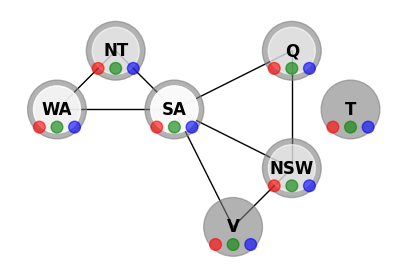

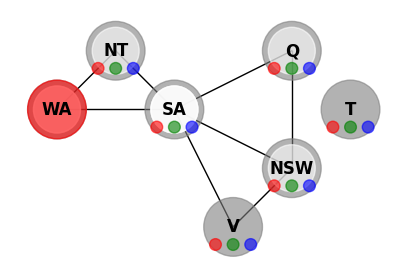

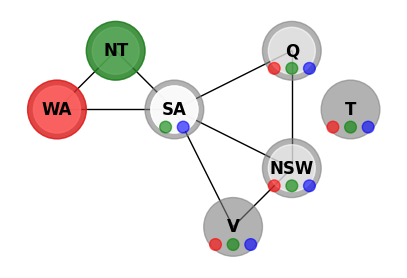

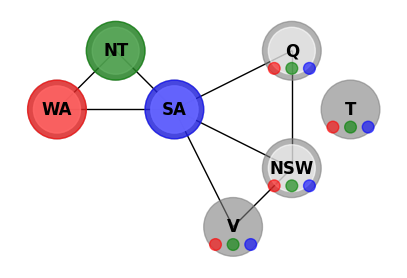

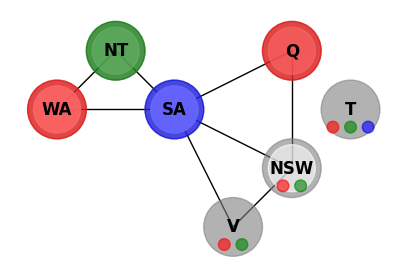

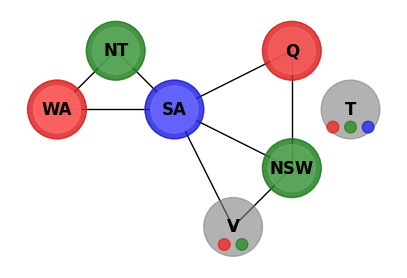

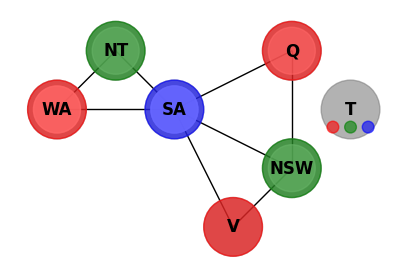

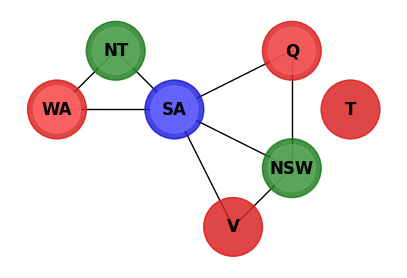

In [63]:
csp = CSP(X, D, constraints)
assignment = backtracking_search(csp)